In [ ]:
#pip install pandas numpy matplotlib seaborn tensorflow scikit-learn

In [2]:
#Imports & Environment Check
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

2026-01-05 15:31:03.787874: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-05 15:31:03.788431: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-05 15:31:03.857844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-05 15:31:05.324834: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [19]:
#Load Training & Test Data
TRAIN_PATH = "../../data/training_data.csv"
TEST_PATH = "../../data/test_data.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print("Training shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Training shape: (8000, 10)
Test shape: (2000, 10)


,job_id,job_title,industry,location,salary_usd,skills_required,remote_option,company_size,posting_date,salary_usd_normalized
0,9255,Blockchain Developer,Blockchain,Singapore,53260,"Ethereum, Rust",1,3,2025-03-05,0.016237
1,1562,Sustainability Analyst,Green Tech,Singapore,185462,"Energy Modeling, Climate Data Analysis",1,1,2025-07-18,0.677323
2,1671,Quantum Software Developer,Quantum Computing,Singapore,87571,"Qiskit, Quantum Algorithms",1,2,2025-07-09,0.187812
3,6088,Smart Contract Engineer,Blockchain,Berlin,128264,"Solidity, Ethereum",0,3,2025-09-08,0.391300
4,6670,Smart Contract Engineer,Blockchain,Dubai,135142,"Rust, Solidity",0,1,2025-08-08,0.425694


In [20]:
#Drop Non-Numeric / Non-Model Columns
TARGET = "salary_usd_normalized"

DROP_COLS = [
    "job_id",
    "job_title",
    "skills_required",
    "posting_date",
    "salary_usd"  # original salary not used
]

X_train = train_df.drop(columns=DROP_COLS + [TARGET])
y_train = train_df[TARGET]

X_test = test_df.drop(columns=DROP_COLS + [TARGET])
y_test = test_df[TARGET]

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (8000, 4)
y_train: (8000,)


In [21]:
#Encode Categorical Variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns (important!)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

print("Encoded feature count:", X_train.shape[1])

Encoded feature count: 10


In [22]:
#Feature Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
#Build Optimized Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber

model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    BatchNormalization(),

    Dense(1, activation="linear")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=Huber(delta=1.0),
    metrics=["mae"]
)

model.summary()

/home/aravi/miniconda3/envs/py312/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,673 (49.50 KB)

 Trainable params: 12,225 (47.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
#Optimized Training Strategy
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=7,
    min_lr=1e-5,
    verbose=1
)

history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1801 - mae: 0.4741 - val_loss: 0.0532 - val_mae: 0.2713 - learning_rate: 0.0010
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0685 - mae: 0.3008 - val_loss: 0.0457 - val_mae: 0.2566 - learning_rate: 0.0010
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0537 - mae: 0.2723 - val_loss: 0.0436 - val_mae: 0.2534 - learning_rate: 0.0010
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0483 - mae: 0.2615 - val_loss: 0.0430 - val_mae: 0.2522 - learning_rate: 0.0010
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0462 - mae: 0.2584 - val_loss: 0.0426 - val_mae: 0.2510 - learning_rate: 0.0010
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0444 - mae: 0.2542 - val_loss: 0.0433 - val_mae: 0.2531 - learning_rate: 0.0010
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0437 - mae: 0.2527 - val_loss: 0.0425 - val_mae: 0.2514 - learning_rate: 0.0010

In [25]:
y_pred = model.predict(X_test_scaled).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Optimized RMSE: {rmse:.4f}")
print(f"Optimized R² Score: {r2:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Optimized RMSE: 0.2881
Optimized R² Score: -0.0058


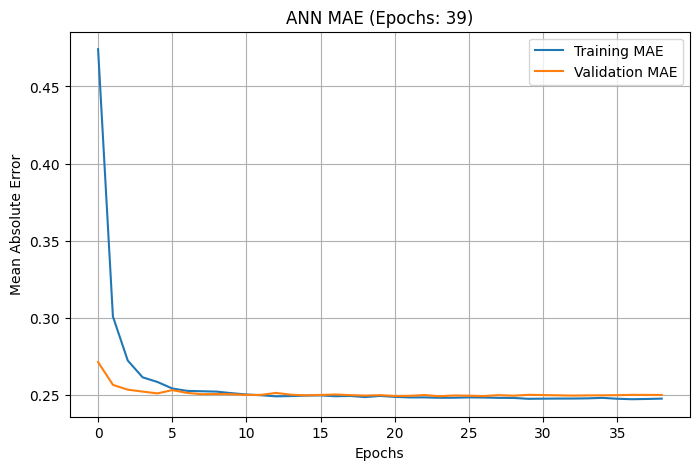

In [41]:
plt.figure(figsize=(8,5))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title(f"ANN MAE (Epochs: {len(history.history['mae'])})")
plt.legend()
plt.grid(True)

# Save figure
plt.savefig("../../documentation/mae_curve.png", dpi=300, bbox_inches="tight")

# Show figure
plt.show()

# Close figure
plt.close()

In [ ]:
#Build ANN Model (TensorFlow)
# model = Sequential([
#     Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
#     Dense(32, activation="relu"),
#     Dense(1, activation="linear")
# ])

# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss="mse",
#     metrics=["mae"]
# )

# model.summary()

/home/aravi/miniconda3/envs/py312/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-05 15:31:50.142931: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#Train the Model
# early_stop = EarlyStopping(
#     monitor="val_loss",
#     patience=10,
#     restore_best_weights=True
# )

# history = model.fit(
#     X_train_scaled,
#     y_train,
#     validation_data=(X_test_scaled, y_test),
#     epochs=100,
#     batch_size=32,
#     callbacks=[early_stop],
#     verbose=1
# )

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0825 - mae: 0.2473 - val_loss: 0.0841 - val_mae: 0.2503
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0825 - mae: 0.2473 - val_loss: 0.0849 - val_mae: 0.2514
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0824 - mae: 0.2472 - val_loss: 0.0842 - val_mae: 0.2504
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0824 - mae: 0.2471 - val_loss: 0.0848 - val_mae: 0.2505
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0823 - mae: 0.2468 - val_loss: 0.0839 - val_mae: 0.2500
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0824 - mae: 0.2473 - val_loss: 0.0842 - val_mae: 0.2502
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0822 - mae: 0.2468 - val_loss: 0.0842 - val_mae: 0.2503
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0823 - mae: 0.2471 - val_loss: 0.0840 - val_mae: 0.2499
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

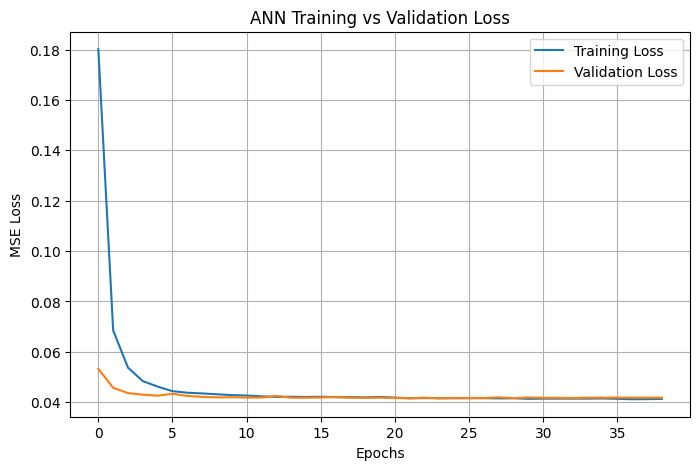

In [40]:
# Training & Validation Loss Curve
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("ANN Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Save figure
plt.savefig("../../documentation/training_curve.png", dpi=300, bbox_inches="tight")

# Show figure
plt.show()

# Close figure (good practice in notebooks)
plt.close()

In [28]:
#Model Evaluation
y_pred = model.predict(X_test_scaled).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 0.2881
R² Score: -0.0058


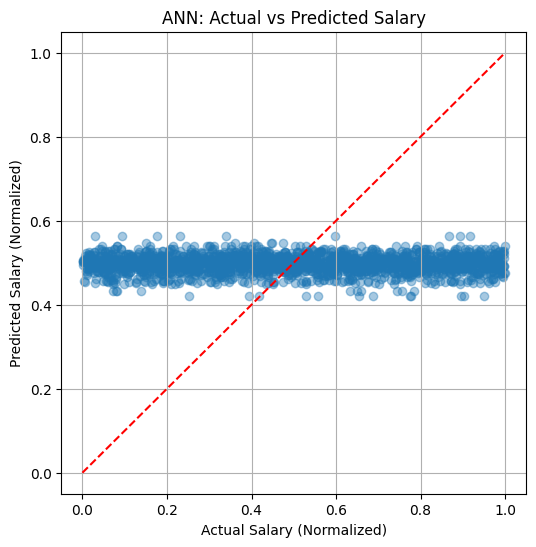

In [29]:
#Predicted vs Actual Scatter Plot 
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("Actual Salary (Normalized)")
plt.ylabel("Predicted Salary (Normalized)")
plt.title("ANN: Actual vs Predicted Salary")
plt.grid(True)
plt.show()

In [30]:
#Save Trained ANN Model
MODEL_PATH = "currentAiSolution.h5"
model.save(MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")

Model saved to currentAiSolution.h5


In [31]:
#Save Metrics for Documentation
metrics_df = pd.DataFrame({
    "RMSE": [rmse],
    "R2": [r2],
    "Final_Train_Loss": [history.history["loss"][-1]],
    "Final_Val_Loss": [history.history["val_loss"][-1]]
})

metrics_df.to_csv("ann_metrics.csv", index=False)
metrics_df

,RMSE,R2,Final_Train_Loss,Final_Val_Loss
0,0.288093,-0.00583,0.041291,0.041776


In [ ]:
##Testing for the Activation Data:
ACTIVATION_PATH = "../../data/activation_data.csv"
TRAIN_PATH = "../../data/training_data.csv"
MODEL_PATH = "currentAiSolution.h5"

activation_df = pd.read_csv(ACTIVATION_PATH)
train_df = pd.read_csv(TRAIN_PATH)

model = tf.keras.models.load_model(MODEL_PATH)

activation_df

,job_id,job_title,industry,location,salary_usd,skills_required,remote_option,company_size,posting_date,salary_usd_normalized
0,4344,Quantum Software Developer,Quantum Computing,Berlin,247645,"Quantum Algorithms, Qiskit",1,2,2025-10-19,0.988274


In [44]:
TARGET = "salary_usd_normalized"

DROP_COLS = [
    "job_id",
    "job_title",
    "skills_required",
    "posting_date",
    "salary_usd"  # original salary
]

In [45]:
# Prepare training features (for column reference)
X_train = train_df.drop(columns=DROP_COLS + [TARGET])
X_train = pd.get_dummies(X_train, drop_first=True)

# Prepare activation features
X_activation = activation_df.drop(columns=DROP_COLS, errors="ignore")
X_activation = pd.get_dummies(X_activation, drop_first=True)

# Align activation columns to training columns
X_activation = X_activation.reindex(columns=X_train.columns, fill_value=0)

print("Activation feature shape:", X_activation.shape)

Activation feature shape: (1, 10)


In [46]:
scaler = StandardScaler()
scaler.fit(X_train)  # fit ONLY on training data

X_activation_scaled = scaler.transform(X_activation)

In [47]:
y_pred_norm = model.predict(X_activation_scaled).flatten()
print("Predicted normalized salary:", y_pred_norm[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Predicted normalized salary: 0.5098743


In [48]:
salary_min = train_df["salary_usd"].min()
salary_max = train_df["salary_usd"].max()

y_pred_usd = y_pred_norm * (salary_max - salary_min) + salary_min

print(f"Predicted Salary (USD): ${y_pred_usd[0]:,.2f}")

Predicted Salary (USD): $151,976.13
